# Validation Experiment

In [1]:
%load_ext lab_black

In [45]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings
import sys
from numpy import interp
from pprint import pprint
import sys
import joblib

from numpy.testing import assert_array_equal

warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    recall_score,
    jaccard_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    precision_score,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    cohen_kappa_score,
    make_scorer,
    precision_recall_fscore_support,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_validate,
    StratifiedShuffleSplit,
    LeaveOneGroupOut,
)
from sklearn.utils import resample
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

import mne
from mne.time_frequency import read_tfrs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids

from eztrack.io import read_derivative_npy

sys.path.append("../../")
from episcalp.features import spike_feature_vector, heatmap_features
from episcalp.io.read import (
    load_persyst_spikes,
    load_reject_log,
    load_derivative_heatmaps,
    map_rejectlog_to_deriv,
    load_all_spatiotemporal_datasets,
)
from episcalp.preprocess.montage import _standard_lobes
from episcalp.utils.utils import NumpyEncoder
from episcalp.cross_validate import exclude_subjects, run_exhaustive_heatmap_evaluation

# if you installed sporf via README
from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def _get_exp_condition(subject, root):
    part_fname = os.path.join(root, "participants.tsv")
    df = pd.read_csv(part_fname, sep="\t")

    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"

    return df[df["participant_id"] == subject]

In [4]:
def convert_experimental_cond_to_y(experimental_condition_list):
    """Encoder for y labels."""
    # Group name keys, assigned y-label values
    experimental_condition_map = {
        "non-epilepsy-normal-eeg": 0,
        "epilepsy-normal-eeg": 1,
        "epilepsy-abnormal-eeg": 2,
    }
    return [experimental_condition_map[cond] for cond in experimental_condition_list]

# Define Data Directories

In [5]:
user = "adam"
if user == "patrick":
    jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
    jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")
elif user == "adam":
    jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
    jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [6]:
bids_roots = [jhroot, jeffroot]

In [7]:
roots = [jhroot, jeffroot]

In [8]:
if user == "adam":
    deriv_dir = Path(
        "/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives"
    )
elif user == "patrick":
    deriv_dir = Path(
        "D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/derivatives"
    )

# Load The Data

In [24]:
deriv_fname = deriv_dir / "spatiotemporal_heatmaps.pickle"

In [34]:
feat_mapping = load_all_spatiotemporal_datasets(roots, deriv_fname, verbose=True)

Loading fragility for /Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids
Loading fragility for /Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root
Loading ssind for /Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids
Loading ssind for /Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root
Loading sourceinfl for /Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids
Loading sourceinfl for /Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root
Loading sinkconn for /Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids
Loading sinkconn for /Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root
Loading sinkind for /Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids
Loading sinkind for /Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root
Loading delta for /Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids
Loading delta for /Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root
Loading thet

In [39]:
feat_mapping_dict = joblib.load(deriv_fname)  # read pickle file
print(feat_mapping_dict.keys())

dict_keys(['fragility', 'ssind', 'sourceinfl', 'sinkconn', 'sinkind', 'delta', 'theta', 'alpha', 'beta'])


In [40]:
print(sys.getsizeof(feat_mapping_dict))

360


## Create Feature Matrix From Spatiotemporal Heatmaps

In [41]:
ex_dataset = feat_mapping_dict["fragility"]
feat_names = list(feat_mapping_dict.keys())
print(ex_dataset.keys())

dict_keys(['subject', 'data', 'ch_names', 'roots', 'bids_path'])


In [37]:
# create feature matrix
features = []
for idx in range(len(ex_dataset["subject"])):
    feature_vec = []
    for name in feat_names:
        dataset = feat_mapping_dict[name].copy()

        # extract data and form feature vector
        data = dataset["data"][idx]
        
        # PCA down the time axis
        data = PCA(n_components=5).fit_transform(data)
        
        ch_names = dataset["ch_names"][idx]
        _feature_vec = heatmap_features(data, ch_names)
        feature_vec.extend(_feature_vec)
    features.append(feature_vec)

features = np.array(features)

print(features.shape)

(125, 45)


In [38]:
for name in feat_names:
    print(name)
    dataset = feat_mapping[name].copy()
    print(len(dataset["subject"]))

fragility
125
ssind
125
sourceinfl
125
sinkconn
125
sinkind
125
delta
125
theta
125
alpha
125
beta
125


# Define Validation Experiment Parameters

In [42]:
scaler = StandardScaler()
y_enc = LabelBinarizer()

In [43]:
dataset = ex_dataset

print(dataset.keys())
# get the y-labels
subjects = np.array(dataset["subject"])
roots = dataset["roots"]

# get the experimental conditions
exp_conditions = []
for subject, root in zip(subjects, roots):
    subj_df = _get_exp_condition(subject, root)
    exp_condition = subj_df["exp_condition"].values[0]
    exp_conditions.append(exp_condition)
print(np.unique(exp_conditions))


dict_keys(['subject', 'data', 'ch_names', 'roots', 'bids_path'])
['epilepsy-abnormal-eeg' 'epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']


In [22]:
# encode y label
y = y_enc.fit_transform(exp_conditions)
y_classes = y_enc.classes_
print(y_enc.classes_)
print(y.shape)

['epilepsy-abnormal-eeg' 'epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']
(125, 3)


In [23]:
# only keep normal EEG
keep_idx = [idx for idx, cond in enumerate(exp_conditions) if "-normal-" in cond]

print(len(keep_idx))

keep_subjects = subjects[keep_idx]
X = features[keep_idx, :]
y = y_enc.fit_transform(np.array(exp_conditions)[keep_idx])
y_classes = y_enc.classes_
print(X.shape, y.shape, keep_subjects.shape)

72
(72, 40) (72, 1) (72,)


In [44]:
# Further subset the subjects if desired
exclusion_criteria = {
    'exp_condition': ['epilepsy-abnormal-eeg'],
    "final_diagnosis": None,
    "epilepsy_type": ["generalized"],
    "epilepsy_hemisphere": None,
    "epilepsy_lobe": None,
}
X, y, keep_subjects = exclude_subjects(
    X, y, keep_subjects, bids_roots, exclusion_criteria
)
print(X.shape, y.shape, keep_subjects.shape)

NameError: name 'X' is not defined

# Define Cross Validation Experiment

In [34]:
n_splits = 20
train_size = 0.7
random_state = 12345

In [35]:
stratified_cv = StratifiedShuffleSplit(
    n_splits=n_splits,
    train_size=train_size,
    random_state=random_state,
)
log_cv = LeaveOneGroupOut()
# cv = BootstrapSplit(n_splits=100, random_state=random_state)

cvs = {
    "stratifiedshuffle": stratified_cv,
    #        "leaveonesubout": log_cv
}

In [36]:
clf_name = "sporf"
# clf_name = 'rf'
clf_name = "lr"
max_features = X.shape[1]

rf_model_params = {
    "n_estimators": 1000,
    "max_features": max_features,
    "n_jobs": -1,
    "random_state": random_state,
}
lr_model_params = {
    "n_jobs": -1,
    "random_state": random_state,
    "penalty": "l1",
    "solver": "liblinear",
}

if clf_name == "rf":
    clf = RandomForestClassifier(**rf_model_params)
elif clf_name == "sporf":
    # only used if you installed cysporf
    clf = ObliqueForestClassifier(**rf_model_params)
elif clf_name == "lr":
    clf = LogisticRegression(**lr_model_params)

# for multiclass
# clf = OneVsRestClassifier(clf)

steps = []
if clf_name == "lr":
    steps.append(StandardScaler())
steps.append(clf)

clf = make_pipeline(*steps)
print(clf)
print(clf.steps)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, penalty='l1', random_state=12345,
                                    solver='liblinear'))])
[('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression(n_jobs=-1, penalty='l1', random_state=12345,
                   solver='liblinear'))]


## Entire Dataset as Training Evaluation

In [38]:
# fit on entire dataset
clf.fit(X, y)

scoring_funcs = {
    "balanced_accuracy": balanced_accuracy_score,
    "cohen_kappa_score": cohen_kappa_score,
    "roc_auc": roc_auc_score,  #  "roc_auc",  # roc_auc_score,
    "f1": f1_score,
    "recall": recall_score,
    "specificity": recall_score,
    "precision": precision_score,
    "jaccard": jaccard_score,
    "average_precision": average_precision_score,
    "neg_brier_score": brier_score_loss,
    "cohen_kappa_score": cohen_kappa_score,
    #     'specificity': '',
}

# evaluate the model performance
train_scores = dict()
for score_name, score_func in scoring_funcs.items():
    y_pred_proba = clf.predict_proba(X)
    if score_name == "specificity":
        score_func = make_scorer(score_func, pos_label=0)
    else:
        score_func = make_scorer(score_func)
    score = score_func(clf, X, y)

    train_scores[score_name] = score

for idx in np.unique(y):
    print(f"Class {idx} has ", len(np.argwhere(y == idx)))
y_pred = clf.predict(X)
print(precision_recall_fscore_support(y, y_pred, average="macro"))
pprint(train_scores)

Class 0 has  37
Class 1 has  35
(0.7083333333333333, 0.7084942084942085, 0.7082770596179819, None)
{'average_precision': 0.6349206349206349,
 'balanced_accuracy': 0.7084942084942085,
 'cohen_kappa_score': 0.41666666666666663,
 'f1': 0.7042253521126761,
 'jaccard': 0.5434782608695652,
 'neg_brier_score': 0.2916666666666667,
 'precision': 0.6944444444444444,
 'recall': 0.7142857142857143,
 'roc_auc': 0.7084942084942085,
 'specificity': 0.7027027027027027}


In [39]:
print(y_enc.classes_)

['epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']


## Run sklearn.cross_validate with CV

In [40]:
print(X.shape, y.shape, subjects.shape)
print(clf)

(72, 40) (72, 1) (125,)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, penalty='l1', random_state=12345,
                                    solver='liblinear'))])


In [41]:
scoring_funcs = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "cohen_kappa_score": make_scorer(cohen_kappa_score),
    "roc_auc": "roc_auc",  # roc_auc_score,
    "f1": "f1",  # f1_score,
    "recall": "recall",  # makerecall_score,
    "precision": "precision",  # precision_score,
    "jaccard": "jaccard",  # jaccard_score,
    "average_precision": "average_precision",  # average_precision_score,
    "neg_brier_score": "neg_brier_score",  # brier_score_loss,
}

scoring = scoring_funcs
print(scoring)

{'balanced_accuracy': make_scorer(balanced_accuracy_score), 'cohen_kappa_score': make_scorer(cohen_kappa_score), 'roc_auc': 'roc_auc', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'jaccard': 'jaccard', 'average_precision': 'average_precision', 'neg_brier_score': 'neg_brier_score'}


In [42]:
cv_scores = {}

for cv_name, cv in cvs.items():
    # run cross-validation
    scores = cross_validate(
        clf,
        X,
        y,
        groups=keep_subjects,
        cv=cv,
        scoring=scoring,
        return_estimator=True,
        return_train_score=False,
        n_jobs=-1,
        error_score="raise",
    )

    # get the estimators
    estimators = scores.pop("estimator")
    cv_scores[cv_name] = scores

In [43]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'test_cohen_kappa_score', 'test_roc_auc', 'test_f1', 'test_recall', 'test_precision', 'test_jaccard', 'test_average_precision', 'test_neg_brier_score'])


# Create Final Results Data Frame

In [162]:
result_df = pd.DataFrame()
idx = 0

result_df["exp"] = ""
result_df.at[1, "exp"] = idx
result_df["heatmaps"] = ""
result_df.at[1, "heatmaps"] = str(feat_names)
result_df["data_shape"] = str(X.shape)
result_df["n_splits"] = n_splits
result_df["n_classes"] = len(y_enc.classes_)
result_df["clf"] = clf_name

for name, score in train_scores.items():
    result_df[f"train_{name}"] = score

for name, scores in cv_scores.items():
    for metric, score in scores.items():
        if not metric.startswith("test_"):
            continue

        result_df[f"{name}_test_{metric}"] = ""
        result_df.at[1, f"{name}_test_{metric}"] = score
        result_df[f"{name}_test_{metric}_avg"] = np.mean(score)
        result_df[f"{name}_test_{metric}_std"] = np.std(score)

In [163]:
display(result_df)

,exp,heatmaps,data_shape,n_splits,n_classes,clf,train_balanced_accuracy,train_cohen_kappa_score,train_roc_auc,train_f1,...,stratifiedshuffle_test_test_precision_std,stratifiedshuffle_test_test_jaccard,stratifiedshuffle_test_test_jaccard_avg,stratifiedshuffle_test_test_jaccard_std,stratifiedshuffle_test_test_average_precision,stratifiedshuffle_test_test_average_precision_avg,stratifiedshuffle_test_test_average_precision_std,stratifiedshuffle_test_test_neg_brier_score,stratifiedshuffle_test_test_neg_brier_score_avg,stratifiedshuffle_test_test_neg_brier_score_std
1,0,"['fragility', 'ss']","(72, 10)",20,2,lr,0.652124,0.304482,0.652124,0.637681,...,0.102713,"[0.35714285714285715, 0.35714285714285715, 0.4...",0.416241,0.090815,"[0.595366759143849, 0.5822740390922209, 0.6189...",0.622046,0.099868,"[-0.26254732236954686, -0.26438256322601067, -...",-0.257057,0.039437


In [164]:
fname = deriv_dir / "normaleeg" / clf_name / "distributional_features.csv"
fname.parent.mkdir(exist_ok=True, parents=True)

In [165]:
if fname.exists():
    buff_df = pd.read_csv(fname, index_col=None)
    result_df = pd.concat((buff_df, result_df), axis=0)
display(result_df)

,exp,heatmaps,data_shape,n_splits,n_classes,train_balanced_accuracy,train_cohen_kappa_score,train_roc_auc,train_f1,train_recall,...,stratifiedshuffle_test_test_jaccard,stratifiedshuffle_test_test_jaccard_avg,stratifiedshuffle_test_test_jaccard_std,stratifiedshuffle_test_test_average_precision,stratifiedshuffle_test_test_average_precision_avg,stratifiedshuffle_test_test_average_precision_std,stratifiedshuffle_test_test_neg_brier_score,stratifiedshuffle_test_test_neg_brier_score_avg,stratifiedshuffle_test_test_neg_brier_score_std,clf
0,0,"['fragility', 'ss', 'delta', 'theta', 'alpha',...","(72, 30)",20,2,0.667181,0.333847,0.667181,0.666667,0.685714,...,[0.2 0.27777778 0.41176471 0.25 0...,0.285687,0.089125,[0.49372719 0.48970335 0.54565788 0.48109832 0...,0.494237,0.050554,[-0.30927876 -0.34497334 -0.27538648 -0.383176...,-0.329053,0.045831,NaN
1,0,['fragility'],"(72, 5)",20,2,0.679151,0.359133,0.679151,0.656716,0.628571,...,[0.33333333 0.33333333 0.5 0.53846154 0...,0.431750,0.114145,[0.81044789 0.57192357 0.61264089 0.77748113 0...,0.651187,0.094269,[-0.2199712 -0.26363898 -0.24912169 -0.211358...,-0.247032,0.034687,NaN
1,0,"['fragility', 'ss']","(72, 10)",20,2,0.652124,0.304482,0.652124,0.637681,0.628571,...,"[0.35714285714285715, 0.35714285714285715, 0.4...",0.416241,0.090815,"[0.595366759143849, 0.5822740390922209, 0.6189...",0.622046,0.099868,"[-0.26254732236954686, -0.26438256322601067, -...",-0.257057,0.039437,lr


In [166]:
result_df.to_csv(fname, index=None)

# Run Everything in a Loop

In [54]:
n_splits = 20
train_size = 0.7
random_state = 12345

In [55]:
clf_name = "sporf"
# clf_name = 'rf'
clf_name = "lr"

feature_type = "distribution"

In [56]:
fname = deriv_dir / "normaleeg" / clf_name / f"{feature_type}_features.csv"
fname.parent.mkdir(exist_ok=True, parents=True)

print(f"File {fname} exists {fname.exists()}")

File /Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/normaleeg/lr/distribution_features.csv exists True


In [77]:
import itertools

idx = 0
for i in range(1, len(feat_names) + 1):
    for names in itertools.combinations(feat_names, i):
        result_df = run_exhaustive_heatmap_evaluation(
            feat_mapping_dict, names=names, feature_types=feature_type, result_fname=fname, 
            clf_name=clf_name, random_state=random_state)

Class 0 has  35
Class 1 has  38
[0.45454545 0.45454545 0.59090909 0.59090909 0.59090909 0.59090909
 0.45454545 0.27272727 0.36363636 0.40909091 0.68181818 0.5
 0.63636364 0.72727273 0.54545455 0.40909091 0.68181818 0.59090909
 0.59090909 0.59090909]
         heatmaps  exp data_shape  n_splits  n_classes clf  \
1  ('fragility',)    0    (73, 5)        20          2  lr   

   train_balanced_accuracy  train_cohen_kappa_score  train_roc_auc  train_f1  \
1                 0.600376                 0.201433       0.600376  0.632911   

   train_recall  train_precision  train_jaccard  train_average_precision  \
1      0.657895         0.609756       0.462963                 0.579238   

   train_neg_brier_score  
1                0.39726  
[-0.09090909 -0.09090909  0.18181818  0.18181818  0.18181818  0.18181818
 -0.09090909 -0.45454545 -0.27272727 -0.18181818  0.36363636  0.
  0.27272727  0.45454545  0.09090909 -0.18181818  0.36363636  0.18181818
  0.18181818  0.18181818]
         heatmaps  e

/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warni

KeyboardInterrupt: 

' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect wh

In [31]:
print(y.shape)
print(y)
print("done")

(70,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1]
done


/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warni

## Plotting

In [33]:
clf_name = "sporf"
fname = deriv_dir / "normaleeg" / clf_name / "distributional_features.csv"

result_df = pd.read_csv(fname, index_col=None)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/normaleeg/sporf/distributional_features.csv'

/Users/adam2392/Documents/scikit-learn/sklearn/pipeline.py:395: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/adam2392/Documents/scikit-learn/sklearn/pipeline.py:395: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/adam2392/Documents/scikit-learn/sklearn/pipeline.py:395: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/adam2392/Documents/scikit-learn/sklearn/pipeline.py:395: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

In [47]:
print(result_df.shape)
# melt the columns

(765, 43)


In [40]:
display(result_df.head())

,exp,heatmaps,data_shape,n_splits,n_classes,clf,train_balanced_accuracy,train_cohen_kappa_score,train_roc_auc,train_f1,...,stratifiedshuffle_test_precision_std,stratifiedshuffle_test_jaccard,stratifiedshuffle_test_jaccard_avg,stratifiedshuffle_test_jaccard_std,stratifiedshuffle_test_average_precision,stratifiedshuffle_test_average_precision_avg,stratifiedshuffle_test_average_precision_std,stratifiedshuffle_test_neg_brier_score,stratifiedshuffle_test_neg_brier_score_avg,stratifiedshuffle_test_neg_brier_score_std
0,0,"('fragility',)","(72, 5)",20,2,sporf,1.0,1.0,1.0,1.0,...,0.107868,[0.5 0.4 0.44444444 0.38461538 0...,0.377132,0.080230,[0.60661312 0.61654705 0.60815123 0.67665668 0...,0.619655,0.085721,[-0.25847551 -0.30035425 -0.32248047 -0.250429...,-0.286790,0.049860
1,0,"('sinkind',)","(72, 5)",20,2,sporf,1.0,1.0,1.0,1.0,...,0.162635,[0.26666667 0.31578947 0.4375 0.46666667 0...,0.396379,0.112436,[0.51335605 0.60239234 0.77914863 0.61095542 0...,0.630520,0.098232,[-0.30665456 -0.27673391 -0.25264114 -0.273063...,-0.266046,0.044520
2,0,"('sinkconn',)","(72, 5)",20,2,sporf,1.0,1.0,1.0,1.0,...,0.117482,[0.38888889 0.4 0.4375 0.25 0...,0.343690,0.117920,[0.58451519 0.62429313 0.59511347 0.54350649 0...,0.550990,0.092667,[-0.26804069 -0.24494928 -0.25251331 -0.270034...,-0.281465,0.044217
3,0,"('sourceinfl',)","(72, 5)",20,2,sporf,1.0,1.0,1.0,1.0,...,0.149515,[0.33333333 0.30769231 0.23529412 0.27777778 0...,0.289958,0.113947,[0.45193943 0.59392606 0.41548814 0.51235847 0...,0.515683,0.092347,[-0.30778801 -0.25209017 -0.34291828 -0.311461...,-0.293711,0.036110
4,0,"('delta',)","(72, 5)",20,2,sporf,1.0,1.0,1.0,1.0,...,0.109524,[0.35714286 0.30769231 0.5 0.61538462 0...,0.429249,0.113321,[0.69406566 0.58666787 0.62199244 0.89057786 0...,0.663948,0.109682,[-0.23959614 -0.30980926 -0.29715162 -0.194056...,-0.264431,0.042623


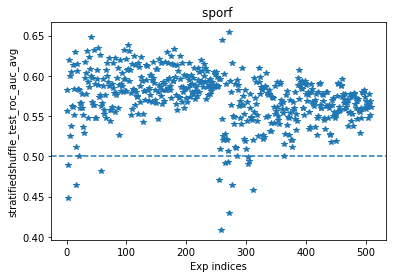

In [41]:
fig, ax = plt.subplots()

y = "stratifiedshuffle_test_roc_auc_avg"
ax.plot(result_df[y], "*")
ax.set(title=f"{clf_name} ", xlabel="Exp indices", ylabel=y)
ax.axhline([0.5], ls="--")

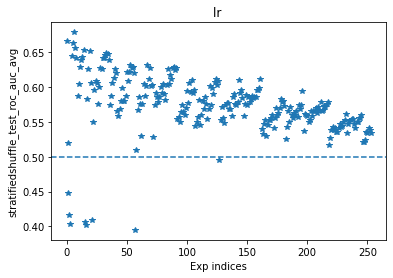

In [73]:
fig, ax = plt.subplots()

y = "stratifiedshuffle_test_roc_auc_avg"
ax.plot(result_df[y], "*")
ax.set(title=f"{clf_name} ", xlabel="Exp indices", ylabel=y)
ax.axhline([0.5], ls="--")

In [ ]:
fig, ax = plt.subplots()

y = "train_roc_auc"
ax.plot(result_df[y], "*")
ax.set(title=f"{clf_name} ", xlabel="Exp indices", ylabel=y)
ax.axhline([0.5], ls="--")

In [96]:
y = "train_roc_auc"
# y = "stratifiedshuffle_test_roc_auc_avg"
ordered_index = np.argsort(result_df[y])[::-1]
names = result_df["heatmaps"][ordered_index[:10]].values

print(result_df[y][ordered_index[:10]])
print(f"Best names: {names}")

204    0.736293
170    0.736293
135    0.736293
247    0.736293
222    0.736293
225    0.736293
201    0.736293
240    0.736293
185    0.735521
212    0.735521
Name: train_roc_auc, dtype: float64
Best names: ["('sinkind', 'sinkconn', 'delta', 'theta', 'beta')"
 "('fragility', 'sinkind', 'sinkconn', 'theta', 'beta')"
 "('sinkind', 'sinkconn', 'theta', 'beta')"
 "('fragility', 'sinkind', 'sinkconn', 'sourceinfl', 'delta', 'theta', 'beta')"
 "('fragility', 'sinkind', 'sinkconn', 'sourceinfl', 'theta', 'beta')"
 "('fragility', 'sinkind', 'sinkconn', 'delta', 'theta', 'beta')"
 "('sinkind', 'sinkconn', 'sourceinfl', 'theta', 'beta')"
 "('sinkind', 'sinkconn', 'sourceinfl', 'delta', 'theta', 'beta')"
 "('fragility', 'sinkconn', 'sourceinfl', 'theta', 'alpha')"
 "('sinkconn', 'sourceinfl', 'delta', 'theta', 'alpha')"]


In [97]:
y = "train_roc_auc"
y = "stratifiedshuffle_test_roc_auc_avg"
ordered_index = np.argsort(result_df[y])[::-1]
names = result_df["heatmaps"][ordered_index[:10]].values

print(result_df[y][ordered_index[:10]])
pprint(f"Best names: {names}")

6     0.678512
0     0.665289
5     0.663223
7     0.655372
14    0.652479
19    0.651240
33    0.649174
34    0.647107
32    0.646281
4     0.643802
Name: stratifiedshuffle_test_roc_auc_avg, dtype: float64
Best names: ["('alpha',)" "('fragility',)" "('theta',)" "('beta',)"
 "('fragility', 'beta')" "('sinkind', 'alpha')" "('theta', 'alpha')"
 "('theta', 'beta')" "('delta', 'beta')" "('delta',)"]


In [42]:
y = "train_roc_auc"
y = "stratifiedshuffle_test_roc_auc_avg"
ordered_index = np.argsort(result_df[y])[::-1]
names = result_df["heatmaps"][ordered_index[:10]].values

print(result_df[y][ordered_index[:10]])
print(f"Best names: {names}")

272    0.654091
41     0.648760
259    0.644773
103    0.638843
53     0.634298
179    0.633884
96     0.632438
46     0.632231
105    0.630992
34     0.630579
Name: stratifiedshuffle_test_roc_auc_avg, dtype: float64
Best names: ["('sinkind', 'delta')" "('fragility', 'sinkind', 'beta')" "('delta',)"
 "('fragility', 'sinkind', 'delta', 'beta')"
 "('fragility', 'delta', 'beta')"
 "('fragility', 'sinkind', 'delta', 'theta', 'beta')"
 "('fragility', 'sinkind', 'sinkconn', 'beta')"
 "('fragility', 'sinkconn', 'beta')"
 "('fragility', 'sinkind', 'theta', 'beta')" "('theta', 'beta')"]


In [72]:
print(result_df["heatmaps"].values)

["('fragility',)" "('sinkind',)" "('sinkconn',)" "('sourceinfl',)"
 "('delta',)" "('theta',)" "('alpha',)" "('beta',)"
 "('fragility', 'sinkind')" "('fragility', 'sinkconn')"
 "('fragility', 'sourceinfl')" "('fragility', 'delta')"
 "('fragility', 'theta')" "('fragility', 'alpha')" "('fragility', 'beta')"
 "('sinkind', 'sinkconn')" "('sinkind', 'sourceinfl')"
 "('sinkind', 'delta')" "('sinkind', 'theta')" "('sinkind', 'alpha')"
 "('sinkind', 'beta')" "('sinkconn', 'sourceinfl')"
 "('sinkconn', 'delta')" "('sinkconn', 'theta')" "('sinkconn', 'alpha')"
 "('sinkconn', 'beta')" "('sourceinfl', 'delta')"
 "('sourceinfl', 'theta')" "('sourceinfl', 'alpha')"
 "('sourceinfl', 'beta')" "('delta', 'theta')" "('delta', 'alpha')"
 "('delta', 'beta')" "('theta', 'alpha')" "('theta', 'beta')"
 "('alpha', 'beta')" "('fragility', 'sinkind', 'sinkconn')"
 "('fragility', 'sinkind', 'sourceinfl')"
 "('fragility', 'sinkind', 'delta')" "('fragility', 'sinkind', 'theta')"
 "('fragility', 'sinkind', 'alpha')"